In [90]:
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import pandas as pd
import gdal
import os
import datetime
import seaborn as sns
from datetime import timedelta
import numpy as np
import fiona
import shapely
from shapely import geometry
from os.path import dirname
import glob
import sys
import pickle
from functools import partial
import geopandas as gp

parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
import zonal_stats as zs
import meteolib as meteo
import evaplib as evap
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','4_temperature'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))
from temperature import SimpleTemperature
from channel import SimpleChannel


try:
    basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
except RuntimeError:
    print 'Cannot find basins shapefile. Please make sure basins shapefile is located in \n the model directory under /raw_data/basins_poly'
basins = gp.read_file(basins)

rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "rb" ) )
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))
temperature_params = pickle.load( open( os.path.join(parent_dir, 'model_data', 'temperature_params.p'), 'rb'))
hill_groups = pickle.load( open( os.path.join(parent_dir,'model_data','solved_hillslope_discharge.p'), "rb" ) )
solved_channel_routing = pickle.load( open( os.path.join(parent_dir,'model_data','solved_channel_routing.p'), "rb" ) )
channel_params = pickle.load( open( os.path.join(parent_dir,'model_data','channel_params.p'), "rb" ))

#start/stop dates for running model  
#spinup date is the date after start_date for which we assume model is finished spinning up         
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_temperature']
resample_freq_channel = model_config['resample_freq_channel']
resample_freq_hillslope = model_config['resample_freq_hillslope']
resample_freq_temperature = model_config['resample_freq_temperature']
t = np.linspace(0,Tmax,np.ceil(Tmax/dt)+1)
timestamps_hillslope = pd.date_range(start_date, stop_date, freq=resample_freq_hillslope)
timestamps_channel = pd.date_range(start_date, stop_date, freq=resample_freq_channel)
timestamps_temperature = pd.date_range(start_date, stop_date, freq=resample_freq_temperature)

streams = glob.glob(os.path.join(parent_dir,'raw_data','streams_poly','*.shp'))[0]
streams_shape = gp.GeoDataFrame.from_file(streams)


In [67]:
ssrs = {rew_id:{} for rew_id in rew_config.keys()}
rew_points = {rew_id:[] for rew_id in rew_config.keys()}

# get dictionary with points list for each rew segment
for i, row in streams_shape.iterrows():
    segment = row.geometry
    pointlist = []
    for coord in segment.coords:
        pointlist.append(coord)
    
    rew_points[row['cat']] = pointlist


        
tifs = glob.glob('/Volumes/zee_data/angelo2m2014_ssr/*.tif')
# for each tif, get mean ssr for each channel
# store that ssr in ssrs dictionary, key on rew_id, then week of ssr
for raster_file in tifs:
    week = raster_file[-7:-4]
    gdata = gdal.Open(raster_file)
    gt = gdata.GetGeoTransform()
    data = gdata.ReadAsArray().astype(np.float)
    gdata = None
    
    for rew_id in rew_points.keys():
        ssr_at_points_in_rew = []
        for pos in rew_points[rew_id]:
            x = int((pos[0] - gt[0])/gt[1])
            y = int((pos[1] - gt[3])/gt[5])
            ssr_at_points_in_rew.append(data[y, x])
            
        ssrs[rew_id][week] = np.mean(ssr_at_points_in_rew)
        


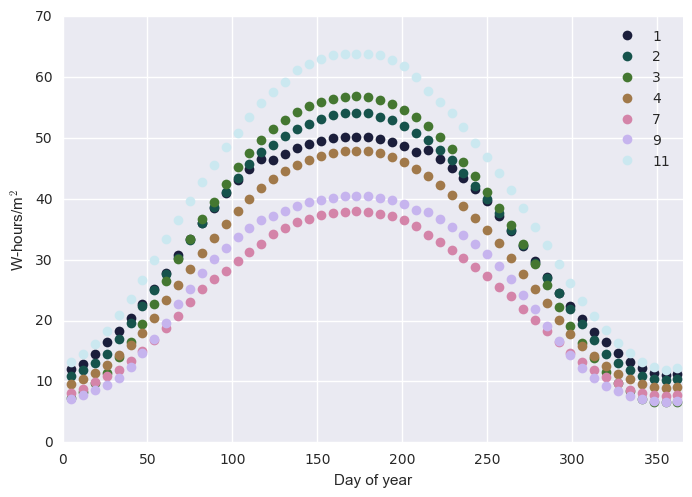

In [111]:
dflist = []
for rew_id in ssrs.keys():
    x = []
    y = []
    for key in ssrs[rew_id].keys():
        x.append(float(key))
        y.append(ssrs[rew_id][key])
    df = pd.DataFrame({rew_id:y},index=x)
    dflist.append(df)

df = pd.concat(dflist,axis=1)
df = df/12.0
sns.set_palette(sns.color_palette("cubehelix", 7))
df.plot(style='o', xlim=[0,365])
plt.xlabel('Day of year')
plt.ylabel(r'W-hours/m$^2$')
plt.savefig('/Users/daviddralle/Desktop/ssr.pdf')